# Network Intrusion Detection with CSE-CIC-IDS2018 Dataset
## A Complete Guide to Building Realistic ML Models Without Data Leakage
---

## 📋 Table of Contents
1. [Introduction & Problem Statement](#introduction)
2. [Understanding Data Leakage](#data-leakage)
3. [Setup and Imports](#setup)
4. [Data Loading and Initial Exploration](#data-loading)
5. [Data Cleaning and Preprocessing](#data-cleaning)
6. [The Critical Issue: Leaky Feature Detection](#leaky-features)
7. [Building the Clean Pipeline](#clean-pipeline)
8. [Model Training and Evaluation](#model-training)
9. [Results Analysis](#results)
10. [Key Lessons Learned](#lessons)


---

## 1. Introduction & Problem Statement <a class="anchor" id="introduction"></a>

### What is Network Intrusion Detection?

Network intrusion detection systems (NIDS) analyze network traffic to identify malicious activities. This is a **binary classification problem**:
- **Benign Traffic**: Normal, legitimate network activity
- **Attack Traffic**: Malicious activities (DoS, Brute Force, etc.)

### The CSE-CIC-IDS2018 Dataset

This dataset contains network flow data with various attack types. However, it has a **critical problem**: many features are engineered in ways that create data leakage, leading to unrealistically high performance.

### Why This Tutorial Matters

Most tutorials show 99%+ accuracy on this dataset, which is **impossible in real-world scenarios**. This notebook teaches you how to:
- Identify and remove data leakage
- Build realistic models that actually work in production
- Understand why 85-90% accuracy is often better than 99%

---

## 2. Understanding Data Leakage <a class="anchor" id="data-leakage"></a>

### What is Data Leakage?

Data leakage occurs when your model has access to information that wouldn't be available in real-world prediction scenarios. This creates artificially high performance that doesn't generalize.

### Why 99% Accuracy is Suspicious

In real network environments:
- Attack patterns vary constantly
- New attack types emerge
- Network conditions change
- **85-90% accuracy is excellent for this domain**

## 3. Setup and Imports <a class="anchor" id="setup"></a>
Alright, let's get our hands dirty. First, we need to set up our environment with all the tools we'll need.


In [1]:
# # import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("solarmainframe/ids-intrusion-csv")

# print("Path to dataset files:", path)

In [2]:
# import os
# for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/solarmainframe/ids-intrusion-csv/versions/1'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))



In [3]:
# # Install required packages (run once)
# %pip install imbalanced-learn xgboost lightgbm scikit-learn pandas numpy matplotlib seaborn

In [73]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency

# Scikit-learn modules
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
# Add these imports to your existing ones
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
# Imbalanced learning
from imblearn.over_sampling import SMOTE

print("All libraries imported successfully!")

All libraries imported successfully!


In [5]:
# Configuration
# warnings.filterwarnings('ignore')
# pd.set_option('display.max_columns', None)
# pd.set_option('display.expand_frame_repr', False)

# # Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

---

## 4. Data Loading and Initial Exploration <a class="anchor" id="data-loading"></a>

### 4.1 Loading Raw Data
I'm going to work with two specific files from the CSE-CIC-IDS2018 dataset:

02-14-2018.csv: Contains brute force attacks (people trying to guess passwords)
02-16-2018.csv: Contains DoS attacks (trying to overwhelm servers)

Why these two? They represent different types of attacks and give us a good variety to work with.

In [6]:
def load_raw_datasets():
    """
    Load the CSE-CIC-IDS2018 datasets

    Why we load specific dates:
    - 02-14-2018.csv: Contains Brute Force attacks
    - 02-16-2018.csv: Contains DoS attacks
    - We focus on these two for simplicity and clear attack patterns
    """

    # Load datasets
    df_brute = pd.read_csv("./archive/02-14-2018.csv")
    df_dos = pd.read_csv("./archive/02-16-2018.csv")

    print(f"Brute Force dataset shape: {df_brute.shape}")
    print(f"DoS dataset shape: {df_dos.shape}")

    # Show basic info
    print(f"\nBrute Force dataset labels:")
    print(df_brute['Label'].value_counts())

    print(f"\nDoS dataset labels:")
    print(df_dos['Label'].value_counts())

    return df_brute, df_dos

In [7]:
# Load the datasets
df_brute, df_dos = load_raw_datasets()

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_28020\483337791.py:13: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dos = pd.read_csv("./archive/02-16-2018.csv")


Brute Force dataset shape: (1048575, 80)
DoS dataset shape: (1048575, 80)

Brute Force dataset labels:
Label
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: count, dtype: int64

DoS dataset labels:
Label
DoS attacks-Hulk            461912
Benign                      446772
DoS attacks-SlowHTTPTest    139890
Label                            1
Name: count, dtype: int64


### 4.2 Label Standardization
**WHY THIS STEP**: The dataset has inconsistent label naming. We standardize them for clarity.

In [8]:
def standardize_labels(df_brute, df_dos):
    """
    Standardize attack labels across datasets

    Original labels are inconsistent:
    - 'FTP-BruteForce' and 'SSH-Bruteforce' → 'BruteForce'
    - 'DoS attacks-Hulk' and 'DoS attacks-SlowHTTPTest' → 'DoS'
    """

    # Standardize Brute Force labels
    df_brute['Label'] = df_brute['Label'].replace({
        'FTP-BruteForce': 'BruteForce',
        'SSH-Bruteforce': 'BruteForce'
    })

    # Standardize DoS labels
    df_dos['Label'] = df_dos['Label'].replace({
        'DoS attacks-Hulk': 'DoS',
        'DoS attacks-SlowHTTPTest': 'DoS',
    })

    print("After standardization:")
    print(f"Brute Force labels: {df_brute['Label'].value_counts().to_dict()}")
    print(f"DoS labels: {df_dos['Label'].value_counts().to_dict()}")

    return df_brute, df_dos

In [9]:
# Standardize labels
df_brute, df_dos = standardize_labels(df_brute, df_dos)

After standardization:
Brute Force labels: {'Benign': 667626, 'BruteForce': 380949}
DoS labels: {'DoS': 601802, 'Benign': 446772, 'Label': 1}


In [10]:
def fixDataType(df_dataset):

    df_dataset = df_dataset[df_dataset['Dst Port'] != 'Dst Port']

    df_dataset['Dst Port'] = df_dataset['Dst Port'].astype(int)
    df_dataset['Protocol'] = df_dataset['Protocol'].astype(int)
    df_dataset['Flow Duration'] = df_dataset['Flow Duration'].astype(int)
    df_dataset['Tot Fwd Pkts'] = df_dataset['Tot Fwd Pkts'].astype(int)
    df_dataset['Tot Bwd Pkts'] = df_dataset['Tot Bwd Pkts'].astype(int)
    df_dataset['TotLen Fwd Pkts'] = df_dataset['TotLen Fwd Pkts'].astype(int)
    df_dataset['TotLen Bwd Pkts'] = df_dataset['TotLen Bwd Pkts'].astype(int)
    df_dataset['Fwd Pkt Len Max'] = df_dataset['Fwd Pkt Len Max'].astype(int)
    df_dataset['Fwd Pkt Len Min'] = df_dataset['Fwd Pkt Len Min'].astype(int)
    df_dataset['Fwd Pkt Len Mean'] = df_dataset['Fwd Pkt Len Mean'].astype(float)
    df_dataset['Fwd Pkt Len Std'] = df_dataset['Fwd Pkt Len Std'].astype(float)
    df_dataset['Bwd Pkt Len Max'] = df_dataset['Bwd Pkt Len Max'].astype(int)
    df_dataset['Bwd Pkt Len Min'] = df_dataset['Bwd Pkt Len Min'].astype(int)
    df_dataset['Bwd Pkt Len Mean'] = df_dataset['Bwd Pkt Len Mean'].astype(float)
    df_dataset['Bwd Pkt Len Std'] = df_dataset['Bwd Pkt Len Std'].astype(float)
    df_dataset['Flow Byts/s'] = df_dataset['Flow Byts/s'].astype(float)
    df_dataset['Flow Pkts/s'] = df_dataset['Flow Pkts/s'].astype(float)
    df_dataset['Flow IAT Mean'] = df_dataset['Flow IAT Mean'].astype(float)
    df_dataset['Flow IAT Std'] = df_dataset['Flow IAT Std'].astype(float)
    df_dataset['Flow IAT Max'] = df_dataset['Flow IAT Max'].astype(int)
    df_dataset['Flow IAT Min'] = df_dataset['Flow IAT Min'].astype(int)
    df_dataset['Fwd IAT Tot'] = df_dataset['Fwd IAT Tot'].astype(int)
    df_dataset['Fwd IAT Mean'] = df_dataset['Fwd IAT Mean'].astype(float)
    df_dataset['Fwd IAT Std'] = df_dataset['Fwd IAT Std'].astype(float)
    df_dataset['Fwd IAT Max'] = df_dataset['Fwd IAT Max'].astype(int)
    df_dataset['Fwd IAT Min'] = df_dataset['Fwd IAT Min'].astype(int)
    df_dataset['Bwd IAT Tot'] = df_dataset['Bwd IAT Tot'].astype(int)
    df_dataset['Bwd IAT Mean'] = df_dataset['Bwd IAT Mean'].astype(float)
    df_dataset['Bwd IAT Std'] = df_dataset['Bwd IAT Std'].astype(float)
    df_dataset['Bwd IAT Max'] = df_dataset['Bwd IAT Max'].astype(int)
    df_dataset['Bwd IAT Min'] = df_dataset['Bwd IAT Min'].astype(int)
    df_dataset['Fwd PSH Flags'] = df_dataset['Fwd PSH Flags'].astype(int)
    df_dataset['Bwd PSH Flags'] = df_dataset['Bwd PSH Flags'].astype(int)
    df_dataset['Fwd URG Flags'] = df_dataset['Fwd URG Flags'].astype(int)
    df_dataset['Bwd URG Flags'] = df_dataset['Bwd URG Flags'].astype(int)
    df_dataset['Fwd Header Len'] = df_dataset['Fwd Header Len'].astype(int)
    df_dataset['Bwd Header Len'] = df_dataset['Bwd Header Len'].astype(int)
    df_dataset['Fwd Pkts/s'] = df_dataset['Fwd Pkts/s'].astype(float)
    df_dataset['Bwd Pkts/s'] = df_dataset['Bwd Pkts/s'].astype(float)
    df_dataset['Pkt Len Min'] = df_dataset['Pkt Len Min'].astype(int)
    df_dataset['Pkt Len Max'] = df_dataset['Pkt Len Max'].astype(int)
    df_dataset['Pkt Len Mean'] = df_dataset['Pkt Len Mean'].astype(float)
    df_dataset['Pkt Len Std'] = df_dataset['Pkt Len Std'].astype(float)
    df_dataset['Pkt Len Var'] = df_dataset['Pkt Len Var'].astype(float)
    df_dataset['FIN Flag Cnt'] = df_dataset['FIN Flag Cnt'].astype(int)
    df_dataset['SYN Flag Cnt'] = df_dataset['SYN Flag Cnt'].astype(int)
    df_dataset['RST Flag Cnt'] = df_dataset['RST Flag Cnt'].astype(int)
    df_dataset['PSH Flag Cnt'] = df_dataset['PSH Flag Cnt'].astype(int)
    df_dataset['ACK Flag Cnt'] = df_dataset['ACK Flag Cnt'].astype(int)
    df_dataset['URG Flag Cnt'] = df_dataset['URG Flag Cnt'].astype(int)
    df_dataset['CWE Flag Count'] = df_dataset['CWE Flag Count'].astype(int)
    df_dataset['ECE Flag Cnt'] = df_dataset['ECE Flag Cnt'].astype(int)
    df_dataset['Down/Up Ratio'] = df_dataset['Down/Up Ratio'].astype(int)
    df_dataset['Pkt Size Avg'] = df_dataset['Pkt Size Avg'].astype(float)
    df_dataset['Fwd Seg Size Avg'] = df_dataset['Fwd Seg Size Avg'].astype(float)
    df_dataset['Bwd Seg Size Avg'] = df_dataset['Bwd Seg Size Avg'].astype(float)
    df_dataset['Fwd Byts/b Avg'] = df_dataset['Fwd Byts/b Avg'].astype(int)
    df_dataset['Fwd Pkts/b Avg'] = df_dataset['Fwd Pkts/b Avg'].astype(int)
    df_dataset['Fwd Blk Rate Avg'] = df_dataset['Fwd Blk Rate Avg'].astype(int)
    df_dataset['Bwd Byts/b Avg'] = df_dataset['Bwd Byts/b Avg'].astype(int)
    df_dataset['Bwd Pkts/b Avg'] = df_dataset['Bwd Pkts/b Avg'].astype(int)
    df_dataset['Bwd Blk Rate Avg'] = df_dataset['Bwd Blk Rate Avg'].astype(int)
    df_dataset['Subflow Fwd Pkts'] = df_dataset['Subflow Fwd Pkts'].astype(int)
    df_dataset['Subflow Fwd Byts'] = df_dataset['Subflow Fwd Byts'].astype(int)
    df_dataset['Subflow Bwd Pkts'] = df_dataset['Subflow Bwd Pkts'].astype(int)
    df_dataset['Subflow Bwd Byts'] = df_dataset['Subflow Bwd Byts'].astype(int)
    df_dataset['Init Fwd Win Byts'] = df_dataset['Init Fwd Win Byts'].astype(int)
    df_dataset['Init Bwd Win Byts'] = df_dataset['Init Bwd Win Byts'].astype(int)
    df_dataset['Fwd Act Data Pkts'] = df_dataset['Fwd Act Data Pkts'].astype(int)
    df_dataset['Fwd Seg Size Min'] = df_dataset['Fwd Seg Size Min'].astype(int)
    df_dataset['Active Mean'] = df_dataset['Active Mean'].astype(float)
    df_dataset['Active Std'] = df_dataset['Active Std'].astype(float)
    df_dataset['Active Max'] = df_dataset['Active Max'].astype(int)
    df_dataset['Active Min'] = df_dataset['Active Min'].astype(int)
    df_dataset['Idle Mean'] = df_dataset['Idle Mean'].astype(float)
    df_dataset['Idle Std'] = df_dataset['Idle Std'].astype(float)
    df_dataset['Idle Max'] = df_dataset['Idle Max'].astype(int)
    df_dataset['Idle Min'] = df_dataset['Idle Min'].astype(int)

    return df_dataset

In [11]:
df_dos = fixDataType(df_dos)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_28020\3083002568.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset['Dst Port'] = df_dataset['Dst Port'].astype(int)
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_28020\3083002568.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset['Protocol'] = df_dataset['Protocol'].astype(int)
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_28020\3083002568.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

### 4.3 Dataset Combination

**WHY COMBINE**: We want to build a general intrusion detector that can identify different attack types, not separate models for each attack.


In [12]:
def combine_datasets(df_brute, df_dos):
    """
    Combine datasets into a single training set

    We shuffle each dataset before combining to ensure:
    1. No temporal ordering bias
    2. Random distribution of samples
    3. Better mixing of attack types
    """
    print("Combining datasets...")

    # Shuffle each dataset independently
    df_brute_shuffled = df_brute.sample(frac=1, random_state=RANDOM_STATE)
    df_dos_shuffled = df_dos.sample(frac=1, random_state=RANDOM_STATE)

    # Combine datasets
    df_combined = pd.concat([df_brute_shuffled, df_dos_shuffled], ignore_index=True)

    print(f"Combined dataset shape: {df_combined.shape}")
    print("\nFinal label distribution:")
    label_dist = df_combined['Label'].value_counts()
    label_pct = (df_combined['Label'].value_counts(normalize=True) * 100).round(2)

    for label in label_dist.index:
        print(f"  {label}: {label_dist[label]:,} samples ({label_pct[label]}%)")

    return df_combined

In [13]:
# Combine datasets
df = combine_datasets(df_brute, df_dos)

Combining datasets...
Combined dataset shape: (2097149, 80)

Final label distribution:
  Benign: 1,114,398 samples (53.14%)
  DoS: 601,802 samples (28.7%)
  BruteForce: 380,949 samples (18.17%)


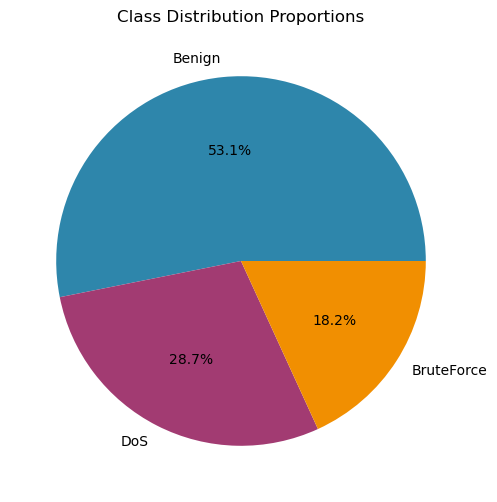

In [14]:
# Class Proportion Pie Chart
import matplotlib.pyplot as plt

label_counts = df['Label'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
        colors=['#2E86AB', '#A23B72', '#F18F01'])
plt.title('Class Distribution Proportions')
plt.show()


---

## 5. Data Cleaning and Preprocessing <a class="anchor" id="data-cleaning"></a>

### 5.1  What's Wrong With This Data?

**CRITICAL**: Before any processing, we need to understand data quality issues.

One of the commen issue in this dataset is have header rows mixed in the data

In [15]:
def assess_data_quality(df):
    """
    Comprehensive data quality assessment

    This step is crucial because the CSE-CIC-IDS2018 dataset has several issues:
    1. Mixed header rows in data
    2. Inconsistent data types
    3. Infinite values
    4. Missing values
    """

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {len(df.columns)}")

    # Check for header rows mixed in data (common issue in this dataset)
    header_rows = df[df['Dst Port'] == 'Dst Port']
    if len(header_rows) > 0:
        print(f"Found {len(header_rows)} header rows mixed in data!")

    # Check data types
    print(f"\nData types summary:")
    df.info()

    # Check for missing values
    missing_counts = df.isnull().sum()
    missing_features = missing_counts[missing_counts > 0]
    if len(missing_features) > 0:
        print(f"\nFeatures with missing values: {len(missing_features)}")


    return header_rows

In [16]:
# Assess data quality
header_issues = assess_data_quality(df)

Dataset shape: (2097149, 80)
Columns: 80

Data types summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097149 entries, 0 to 2097148
Data columns (total 80 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   Protocol           int64  
 2   Timestamp          object 
 3   Flow Duration      int64  
 4   Tot Fwd Pkts       int64  
 5   Tot Bwd Pkts       int64  
 6   TotLen Fwd Pkts    int64  
 7   TotLen Bwd Pkts    int64  
 8   Fwd Pkt Len Max    int64  
 9   Fwd Pkt Len Min    int64  
 10  Fwd Pkt Len Mean   float64
 11  Fwd Pkt Len Std    float64
 12  Bwd Pkt Len Max    int64  
 13  Bwd Pkt Len Min    int64  
 14  Bwd Pkt Len Mean   float64
 15  Bwd Pkt Len Std    float64
 16  Flow Byts/s        float64
 17  Flow Pkts/s        float64
 18  Flow IAT Mean      float64
 19  Flow IAT Std       float64
 20  Flow IAT Max       int64  
 21  Flow IAT Min       int64  
 22  Fwd IAT Tot        int64  
 23  Fwd IAT Mean       f

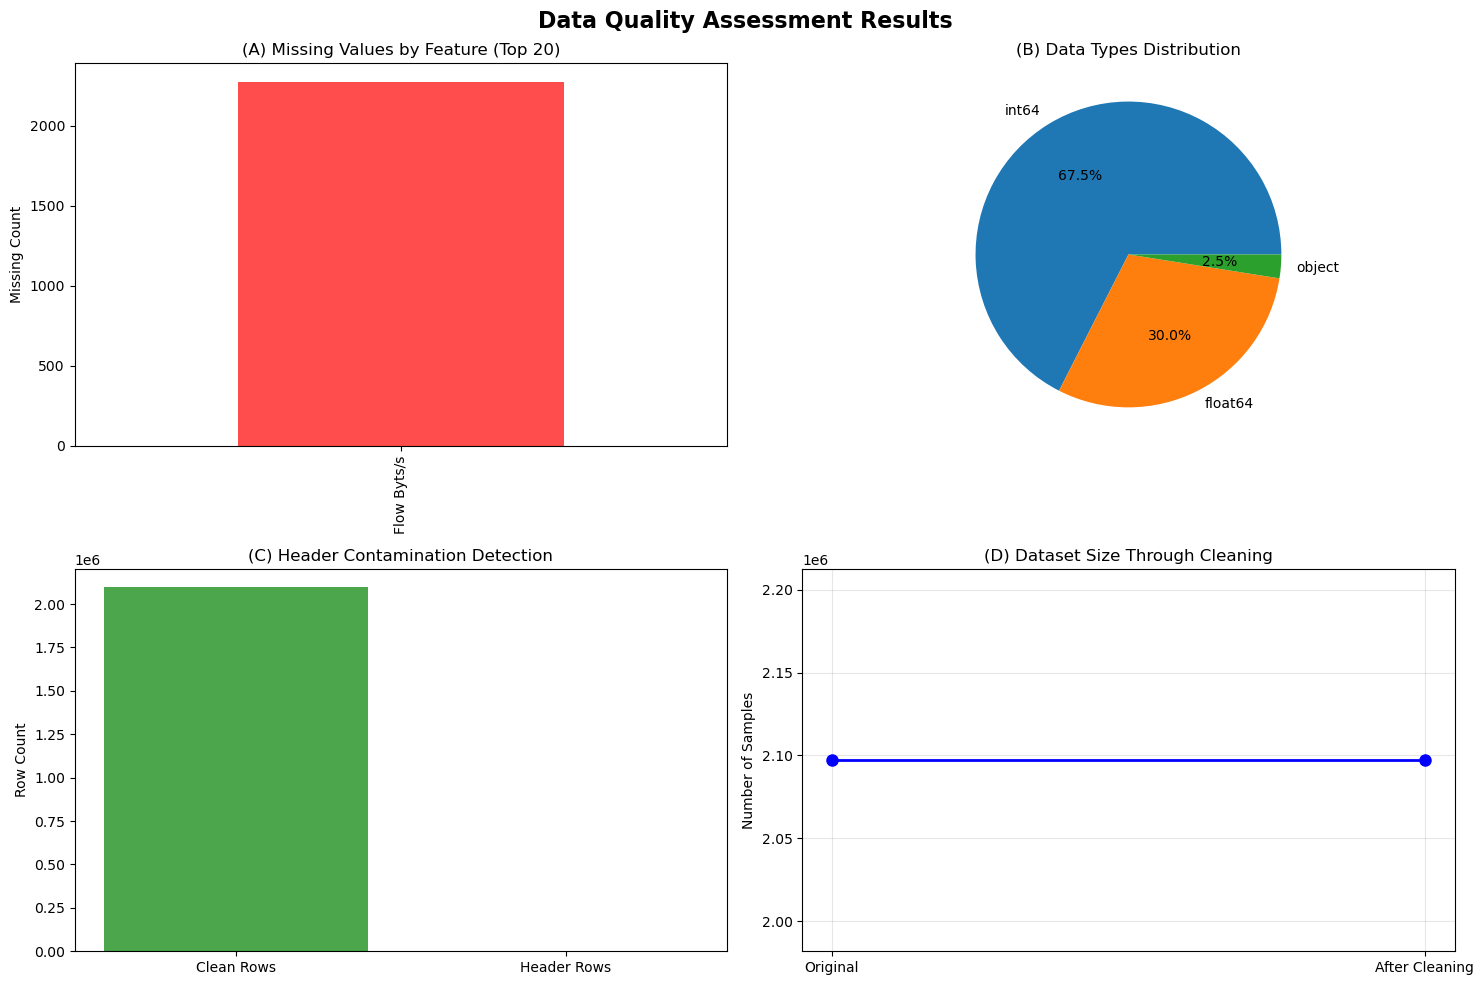

In [17]:
# Data Quality Assessment Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Data Quality Assessment Results', fontsize=16, fontweight='bold')

# A) Missing Values Heatmap (sample)
missing_data = df.isnull().sum().head(20)
if missing_data.sum() > 0:
    missing_data[missing_data > 0].plot(kind='bar', ax=axes[0,0], color='red', alpha=0.7)
    axes[0,0].set_title('(A) Missing Values by Feature (Top 20)')
    axes[0,0].set_ylabel('Missing Count')
else:
    axes[0,0].text(0.5, 0.5, 'No Missing Values Found', ha='center', va='center', fontsize=12)
    axes[0,0].set_title('(A) Missing Values Status')

# B) Data Types Distribution
dtype_counts = df.dtypes.value_counts()
axes[0,1].pie(dtype_counts.values, labels=dtype_counts.index, autopct='%1.1f%%')
axes[0,1].set_title('(B) Data Types Distribution')

# C) Header Contamination
header_status = ['Clean Rows', 'Header Rows']
header_counts = [len(df) - len(header_issues), len(header_issues)]
axes[1,0].bar(header_status, header_counts, color=['green', 'red'], alpha=0.7)
axes[1,0].set_title('(C) Header Contamination Detection')
axes[1,0].set_ylabel('Row Count')

# D) Dataset Shape Evolution
cleaning_steps = ['Original', 'After Cleaning']
shape_evolution = [df.shape[0], df.shape[0]]
axes[1,1].plot(cleaning_steps, shape_evolution, marker='o', linewidth=2, markersize=8, color='blue')
axes[1,1].set_title('(D) Dataset Size Through Cleaning')
axes[1,1].set_ylabel('Number of Samples')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
 # Sample a few rows to see the data
print(f"\nSample data:")
df.head()


Sample data:


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,17,14/02/2018 08:44:26,36517,2,2,80,204,40,40,...,8,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,49906,6,14/02/2018 09:31:42,51,1,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,80,6,14/02/2018 04:13:41,53514166,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,443,6,14/02/2018 11:05:34,272,3,0,77,0,46,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,53,17,14/02/2018 03:23:23,1219,1,1,40,100,40,40,...,8,0.0,0.0,0,0,0.0,0.0,0,0,Benign


### 5.2 Fixing the Data Issues

**KEY PRINCIPLE**: Clean conservatively to preserve as much real data as possible.

Robust data cleaning that preserves data while fixing issues
    
Steps:
1. Remove header rows mixed in data
2. Convert features to appropriate numeric types
3. Handle infinite values carefully
4. Fill missing values conservatively
5. Remove only exact duplicates

In [19]:
df = df.drop(columns=['Timestamp'])

In [20]:
def remove_header_rows(df):
    return df[df['Dst Port'] != 'Dst Port'].copy()

In [21]:
def convert_to_numeric(df):
    conversion_errors = {}
    for col in df.columns:
        if col != 'Label':
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if df[col].isnull().sum() > 0:
                conversion_errors[col] = df[col].isnull().sum()
    return df, conversion_errors


In [22]:
def handle_infinite_values(df):
    inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
    df = df.replace([np.inf, -np.inf], np.nan)
    return df, inf_count


In [23]:
def drop_mostly_empty_rows(df, threshold=0.2):
    feature_columns = [col for col in df.columns if col != 'Label']
    return df.dropna(thresh=len(feature_columns) - len(feature_columns)*threshold)

In [24]:
def fill_missing_with_median(df):
    for col in df.columns:
        if col != 'Label':
            median_val = df[col].median()
            df[col].fillna(0 if pd.isna(median_val) else median_val, inplace=True)
    return df

In [25]:
def remove_duplicates(df):
    return df.drop_duplicates()

In [26]:
def clean_data(df):
    print("Cleaning...")
    df = remove_header_rows(df)
    df, conversion_errors = convert_to_numeric(df)
    df, inf_count = handle_infinite_values(df)
    df = drop_mostly_empty_rows(df)
    df = fill_missing_with_median(df)
    df = remove_duplicates(df)
    if df.isnull().sum().sum() > 0:
        df = df.fillna(0)
    print("Done.")
    return df

In [27]:
df_clean = clean_data(df)

Cleaning...


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_28020\723107744.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0 if pd.isna(median_val) else median_val, inplace=True)


Done.


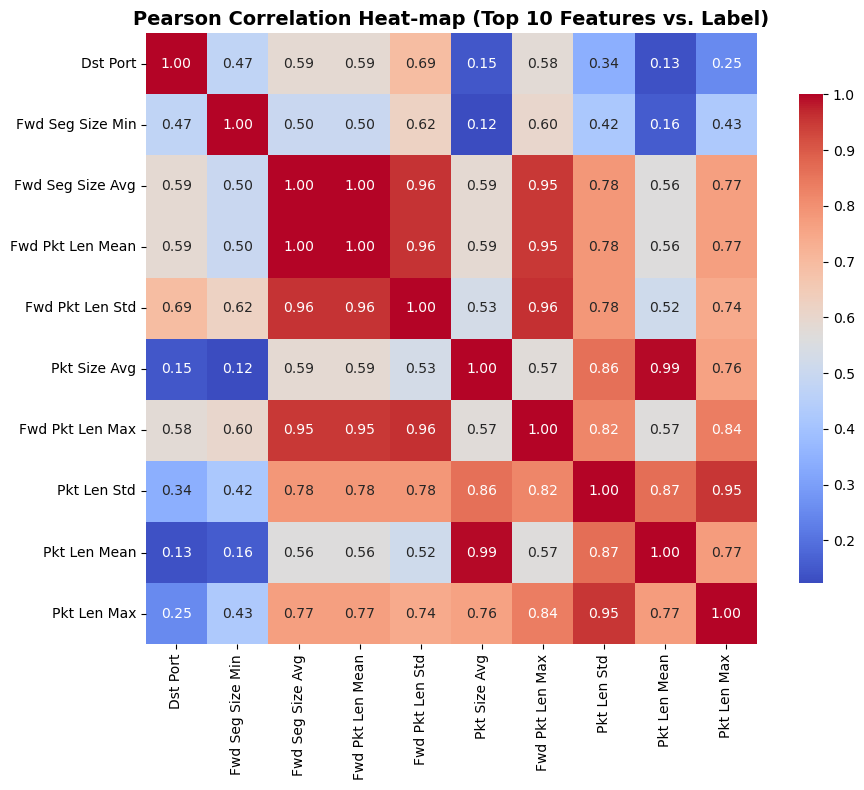

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# ------------------------------------------------------------
# A)  Ensure label is numeric
# ------------------------------------------------------------
label_col = 'Label'                      # ← change if needed
df_corr = df_clean.copy()

if not np.issubdtype(df_corr[label_col].dtype, np.number):
    df_corr[label_col] = LabelEncoder().fit_transform(df_corr[label_col])

# ------------------------------------------------------------
# B)  Pick top-10 predictors most correlated with the label
# ------------------------------------------------------------
corrs      = df_corr.corr(numeric_only=True)[label_col].abs()
top_feats  = corrs.sort_values(ascending=False).iloc[1:11].index   # skip label

# ------------------------------------------------------------
# C)  Draw heat-map
# ------------------------------------------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr[top_feats].corr(),
            cmap='coolwarm', annot=True, fmt='.2f',
            square=True, cbar_kws={'shrink': 0.8})
plt.title('Pearson Correlation Heat-map (Top 10 Features vs. Label)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


---

## 6. The Critical Issue: Leaky Feature Detection <a class="anchor" id="leaky-features"></a>
We need to find the features that are basically cheating - making our problem artificially easy.

### 6.1 Understanding Leaky Features

**THE MOST IMPORTANT SECTION**: This is why most tutorials show unrealistic 99%+ accuracy.

Educational explanation of leaky features in network security datasets

**UNDERSTANDING LEAKY FEATURES**

---

**WHAT ARE LEAKY FEATURES?**

Features that have an unrealistic relationship with the target variable, making prediction artificially easy.
    
**EXAMPLES IN NETWORK DATA:**

❌ LEAKY FEATURE: 'Protocol'
- If all DoS attacks use protocol=6 and all benign traffic uses protocol=17
- The model just memorizes: protocol=6 → Attack, protocol=17 → Benign
- This won't work in real networks where attacks can use any protocol

❌ LEAKY FEATURE: 'Tot Fwd Pkts' (Total Forward Packets)
- If all attacks have exactly 0 forward packets
- The model learns: Tot_Fwd_Pkts=0 → Attack
- Real attacks don't have such perfect patterns

✅ CLEAN FEATURE: 'Flow Duration'
- The time a network flow lasts
- Attacks might tend to have shorter/longer flows, but not perfectly
- Requires actual learning to distinguish patterns

WHY THIS MATTERS:
- Leaky models get 99% accuracy in testing but fail in production
- Clean models get 85-90% accuracy but actually work in real networks
- It's better to have realistic expectations than false confidence

---

### 6.2 Leaky Feature Detection Pipeline

**ADVANCED TECHNIQUE**: Systematically detect features that cause data leakage.

Comprehensive leaky feature detection system
    
Uses multiple methods to identify features that make prediction unrealistically easy:
1. Perfect correlation detection
2. Perfect class separation detection  
3. Statistical independence testing
4. Single-feature model performance testing

Method 1: Find features with near-perfect correlation to target
        
Why this works:
- Real features rarely have >99% correlation with outcomes
- Perfect correlation usually means the feature was engineered using label info


In [29]:
def detect_perfect_correlation(X, y, threshold=0.99):
    print("Method 1: Checking correlations...")

    leaky_features = []
    suspicious_features = []

    for col in X.columns:
        try:
            corr = np.corrcoef(X[col], y)[0, 1]
            if not np.isnan(corr):
                if abs(corr) > threshold:
                    leaky_features.append(col)
                    print(f"🚨 LEAKY (perfect correlation): {col} (r={corr:.4f})")
                elif abs(corr) > 0.95:  # Still very high
                    suspicious_features.append(col)
                    print(f"⚠️  SUSPICIOUS (high correlation): {col} (r={corr:.4f})")
        except:
            continue

    return leaky_features, suspicious_features

Method 2: Find features where some values appear in only one class
        
Why this works:
- Real network features have overlapping distributions between classes
- Perfect separation means the feature perfectly predicts the class

In [30]:
def detect_perfect_separation(X, y):
    print("Method 2: Checking for perfect class separation...")

    leaky_features = []

    for col in X.columns:
        try:
            unique_vals = X[col].nunique()
            # Only check discrete features (not continuous)
            if 1 < unique_vals < 1000:
                crosstab = pd.crosstab(X[col], y)

                # If any feature value appears in only one class
                if (crosstab == 0).any().any():
                    leaky_features.append(col)
                    print(f"🚨 LEAKY (perfect separation): {col}")
        except:
            continue

    return leaky_features

Method 3: Statistical independence testing using Chi-square
    
Why this works:
- Tests if feature distribution is completely dependent on class
- Extremely low p-values indicate perfect dependence (leakage)


In [31]:
def detect_statistical_dependence(X, y):
    print("Method 3: Statistical independence testing...")

    suspicious_features = []

    for col in X.columns:
        try:
            # Discretize continuous variables for chi-square test
            if X[col].nunique() > 20:
                X_discretized = pd.cut(X[col], bins=10, duplicates='drop')
            else:
                X_discretized = X[col]

            crosstab = pd.crosstab(X_discretized, y)
            if crosstab.shape[0] > 1 and crosstab.shape[1] > 1:
                chi2, p_value, dof, expected = chi2_contingency(crosstab)

                # Extremely low p-value indicates perfect dependence
                if p_value < 1e-10:
                    suspicious_features.append(col)
                    print(f"⚠️  SUSPICIOUS (perfect dependence): {col} (p={p_value:.2e})")
        except:
            continue

    return suspicious_features

Method 4: Test if single features can achieve unrealistic performance

Why this works:
- No single real feature should be able to perfectly predict network attacks
- If one feature gives >95% accuracy, it's likely leaky

In [32]:
def detect_single_feature_performance(X, y, sample_size=20, threshold=0.95):
    print("🔍 Method 4: Single feature model testing...")

    suspicious_features = []

    # Test a sample of features (testing all takes too long)
    sample_features = X.columns[:20] if len(X.columns) > 20 else X.columns

    for col in sample_features:
        try:
            # Train simple model on single feature
            rf_single = RandomForestClassifier(n_estimators=10, random_state=RANDOM_STATE)
            rf_single.fit(X[[col]], y)

            accuracy = rf_single.score(X[[col]], y)
            if accuracy > 0.95:
                suspicious_features.append(col)
                print(f"⚠️  SUSPICIOUS (single feature accuracy): {col} (acc={accuracy:.4f})")
        except:
            continue

    return suspicious_features

Run all detection methods and combine results


In [33]:
class LeakyFeatureDetector:
    def __init__(self):
        self.leaky_features = []
        self.suspicious_features = []

    def detect_all(self, X, y):
        print("🚨 Starting Leaky Feature Detection...")

        l_corr, s_corr = detect_perfect_correlation(X, y)
        l_sep = detect_perfect_separation(X, y)
        s_stat = detect_statistical_dependence(X, y)
        s_perf = detect_single_feature_performance(X, y)

        self.leaky_features = list(set(l_corr + l_sep))
        self.suspicious_features = list(set(s_corr + s_stat + s_perf))
        self.suspicious_features = [f for f in self.suspicious_features if f not in self.leaky_features]

        print(f"\n🚨 Found {len(self.leaky_features)} definitely leaky features")
        print(f"⚠️  Found {len(self.suspicious_features)} suspicious features")

        return self.leaky_features, self.suspicious_features


In [34]:
# Example usage of the detector (we'll use this in the next section)
detector = LeakyFeatureDetector()

### 6.3 Running Leaky Feature Detection

**PRACTICAL APPLICATION**: Let's find the leaky features in our dataset.

In [35]:
def get_features(df, target_column="Label"):
    return df.drop(target_column, axis=1).copy()

In [36]:
def make_binary_labels(df, normal_label="Benign", target_column="Label"):
    """
    Transform multi-class labels to binary format (0 = Benign, 1 = Attack).
    """
    return (df[target_column] != normal_label).astype(int)


In [37]:
def make_multiclass_labels(df, target_column="Label"):
    """
    Return the original, unmodified class labels (string format).

    Helpful when you want to train a multi-class model later or need to
    examine the original category names.
    """
    return df[target_column].copy()


In [38]:
def run_leaky_feature_detection(df_clean, test_size: float = 0.2):
    """
    Apply leaky-feature detection on *binary* labels.

    You can still call the helper functions above elsewhere for
    multi-class work; this routine stays focused on the binary task.
    """
    print("RUNNING LEAKY FEATURE DETECTION ON OUR DATASET")

    # 1️  Build X and y (binary)

    X = get_features(df_clean, target_column="Label")
    y = make_binary_labels(df_clean, normal_label="Benign", target_column="Label")

    # 2️  Train/test split (detection on training data only)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=RANDOM_STATE
    )

    print(f"Detection dataset: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Class distribution: Benign={ (y_train==0).sum() }, Attack={ (y_train==1).sum() }")

    # 3 Run detector
    detector = LeakyFeatureDetector()
    leaky_features, suspicious_features = detector.detect_all(X_train, y_train)

    return leaky_features, suspicious_features, X_train, X_test, y_train, y_test


In [39]:
# Run the detection
leaky_features, suspicious_features, X_train, X_test, y_train, y_test = run_leaky_feature_detection(df_clean)

RUNNING LEAKY FEATURE DETECTION ON OUR DATASET
Detection dataset: 1013367 samples, 78 features
Class distribution: Benign=821888, Attack=191479
🚨 Starting Leaky Feature Detection...
Method 1: Checking correlations...


c:\Users\ThinkPad\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ThinkPad\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Method 2: Checking for perfect class separation...
🚨 LEAKY (perfect separation): Protocol
🚨 LEAKY (perfect separation): Tot Fwd Pkts
🚨 LEAKY (perfect separation): Tot Bwd Pkts
🚨 LEAKY (perfect separation): Fwd Pkt Len Min
🚨 LEAKY (perfect separation): Bwd Pkt Len Max
🚨 LEAKY (perfect separation): Bwd Pkt Len Min
🚨 LEAKY (perfect separation): Fwd PSH Flags
🚨 LEAKY (perfect separation): Pkt Len Min
🚨 LEAKY (perfect separation): SYN Flag Cnt
🚨 LEAKY (perfect separation): RST Flag Cnt
🚨 LEAKY (perfect separation): ECE Flag Cnt
🚨 LEAKY (perfect separation): Down/Up Ratio
🚨 LEAKY (perfect separation): Subflow Fwd Pkts
🚨 LEAKY (perfect separation): Subflow Bwd Pkts
🚨 LEAKY (perfect separation): Fwd Act Data Pkts
🚨 LEAKY (perfect separation): Fwd Seg Size Min
Method 3: Statistical independence testing...
⚠️  SUSPICIOUS (perfect dependence): Dst Port (p=0.00e+00)
⚠️  SUSPICIOUS (perfect dependence): Protocol (p=0.00e+00)
⚠️  SUSPICIOUS (perfect dependence): Tot Fwd Pkts (p=5.03e-11)
⚠️  SUSPICI

In [40]:
# # Figure 1: Dataset Overview and Quality Issues
# fig, axes = plt.subplots( figsize=(12, 10))
# fig.suptitle('Figure 1: Dataset Overview and Data Quality Analysis', fontsize=14, fontweight='bold')

# # A) Class Distribution
# df['Label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['lightblue', 'salmon', 'lightgreen'])
# axes[0,0].set_title('(A) Class Distribution in Combined Dataset')
# axes[0,0].set_xlabel('Attack Type')
# axes[0,0].set_ylabel('Number of Samples')
# axes[0,0].tick_params(axis='x', rotation=45)
# #
# # # B) Data Quality Issues
# # quality_issues = ['Header Rows', 'Infinite Values', 'Missing Values', 'Type Inconsistencies']
# # issue_counts = [len(data_problems), inf_count if 'inf_count' in locals() else 0,
# #                 df.isnull().sum().sum(), len([col for col in df.columns if df[col].dtype == 'object' and col != 'Label'])]
# # axes[0,1].bar(quality_issues, issue_counts, color=['red', 'orange', 'yellow', 'pink'], alpha=0.7)
# # axes[0,1].set_title('(B) Data Quality Issues Found')
# # axes[0,1].set_ylabel('Count')
# # axes[0,1].tick_params(axis='x', rotation=45)

# # # C) Before/After Cleaning
# # sizes = ['Before Cleaning', 'After Cleaning']
# # sample_counts = [df.shape[0], df_clean.shape[0]]
# # colors = ['lightcoral', 'lightgreen']
# # bars = axes[1,0].bar(sizes, sample_counts, color=colors, alpha=0.7)
# # axes[1,0].set_title('(C) Dataset Size: Before vs After Cleaning')
# # axes[1,0].set_ylabel('Number of Samples')
# # # Add value labels on bars
# # for bar, count in zip(bars, sample_counts):
# #     axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sample_counts)*0.01,
# #                    f'{count:,}', ha='center', fontweight='bold')

# # # D) Feature Categories After Leakage Detection
# # if 'clean_features' in locals():
# #     categories = ['Clean Features', 'Definitely Leaky', 'Suspicious']
# #     sizes = [len(clean_features), len(cheating_features), len(suspicious_features)]
# #     colors = ['green', 'red', 'orange']
# #     axes[1,1].pie(sizes, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
# #     axes[1,1].set_title('(D) Feature Classification Results')

# plt.tight_layout()
# plt.show()

Generating correlation analysis...


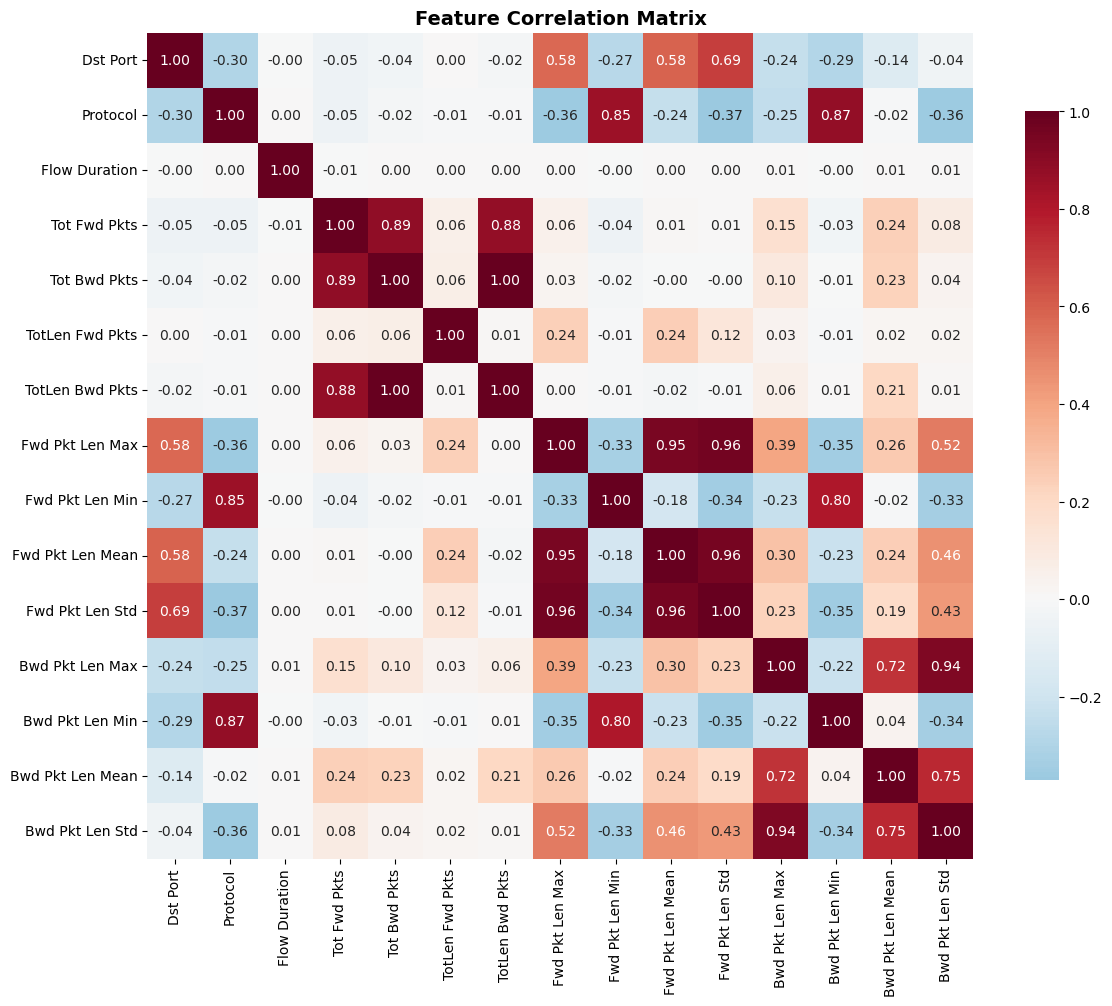

In [41]:
# Add this after leaky feature detection
print("Generating correlation analysis...")

# Select numeric features for correlation analysis
numeric_features = X_train.select_dtypes(include=[np.number]).columns[:15]  # Top 15 for readability
correlation_matrix = X_train[numeric_features].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 6.4 Progressive Feature Removal Testing

**VALIDATION**: Test how removing features affects model performance.


Test model performance as we progressively remove problematic features

This helps us understand:
1. How much each group of features contributes to unrealistic performance
2. What realistic performance looks like
3. The trade-off between accuracy and realism


In [42]:
def test_progressive_feature_removal(X_train, X_test, y_train, y_test, leaky_features, suspicious_features):
    print("\n" + "="*60)
    print("PROGRESSIVE FEATURE REMOVAL TESTING")
    print("="*60)

    # Define test scenarios
    scenarios = [
        ("Original (all features)", X_train, X_test),
        ("Remove definitely leaky",
         X_train.drop(leaky_features, axis=1, errors='ignore'),
         X_test.drop(leaky_features, axis=1, errors='ignore')),
        ("Remove all suspicious",
         X_train.drop(leaky_features + suspicious_features, axis=1, errors='ignore'),
         X_test.drop(leaky_features + suspicious_features, axis=1, errors='ignore'))
    ]

    results = {}

    for scenario_name, X_train_scenario, X_test_scenario in scenarios:
        if X_train_scenario.shape[1] == 0:
            print(f"\n{scenario_name}: No features left - skipping")
            continue

        print(f"\n{'='*20} {scenario_name} {'='*20}")
        print(f"Features remaining: {X_train_scenario.shape[1]}")

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_scenario)
        X_test_scaled = scaler.transform(X_test_scenario)

        # Train a simple model (conservative settings to avoid overfitting)
        rf = RandomForestClassifier(
            n_estimators=20,      # Few trees
            max_depth=3,          # Very shallow
            min_samples_split=100, # Many samples required to split
            min_samples_leaf=50,   # Many samples in leaves
            random_state=RANDOM_STATE
        )

        rf.fit(X_train_scaled, y_train)
        y_pred = rf.predict(X_test_scaled)
        y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test AUC: {auc:.4f}")

        # Interpret results
        if accuracy > 0.98:
                print("🚨 STILL TOO HIGH - more leakage exists!")
        elif accuracy > 0.90:
            print("✅ REASONABLE - but could be better")
        else:
            print("✅ GOOD - realistic performance")

        results[scenario_name] = {
            'accuracy': accuracy,
            'auc': auc,
            'n_features': X_train_scenario.shape[1]
        }

    return results

In [43]:
# Run the progressive testing
removal_results = test_progressive_feature_removal(
    X_train, X_test, y_train, y_test, leaky_features, suspicious_features
)


PROGRESSIVE FEATURE REMOVAL TESTING

==================== Original (all features) ====================
Features remaining: 78
Test Accuracy: 0.9782
Test AUC: 0.9961
✅ REASONABLE - but could be better

==================== Remove definitely leaky ====================
Features remaining: 62
Test Accuracy: 0.9938
Test AUC: 0.9997
🚨 STILL TOO HIGH - more leakage exists!

==================== Remove all suspicious ====================
Features remaining: 34
Test Accuracy: 0.9781
Test AUC: 0.9927
✅ REASONABLE - but could be better


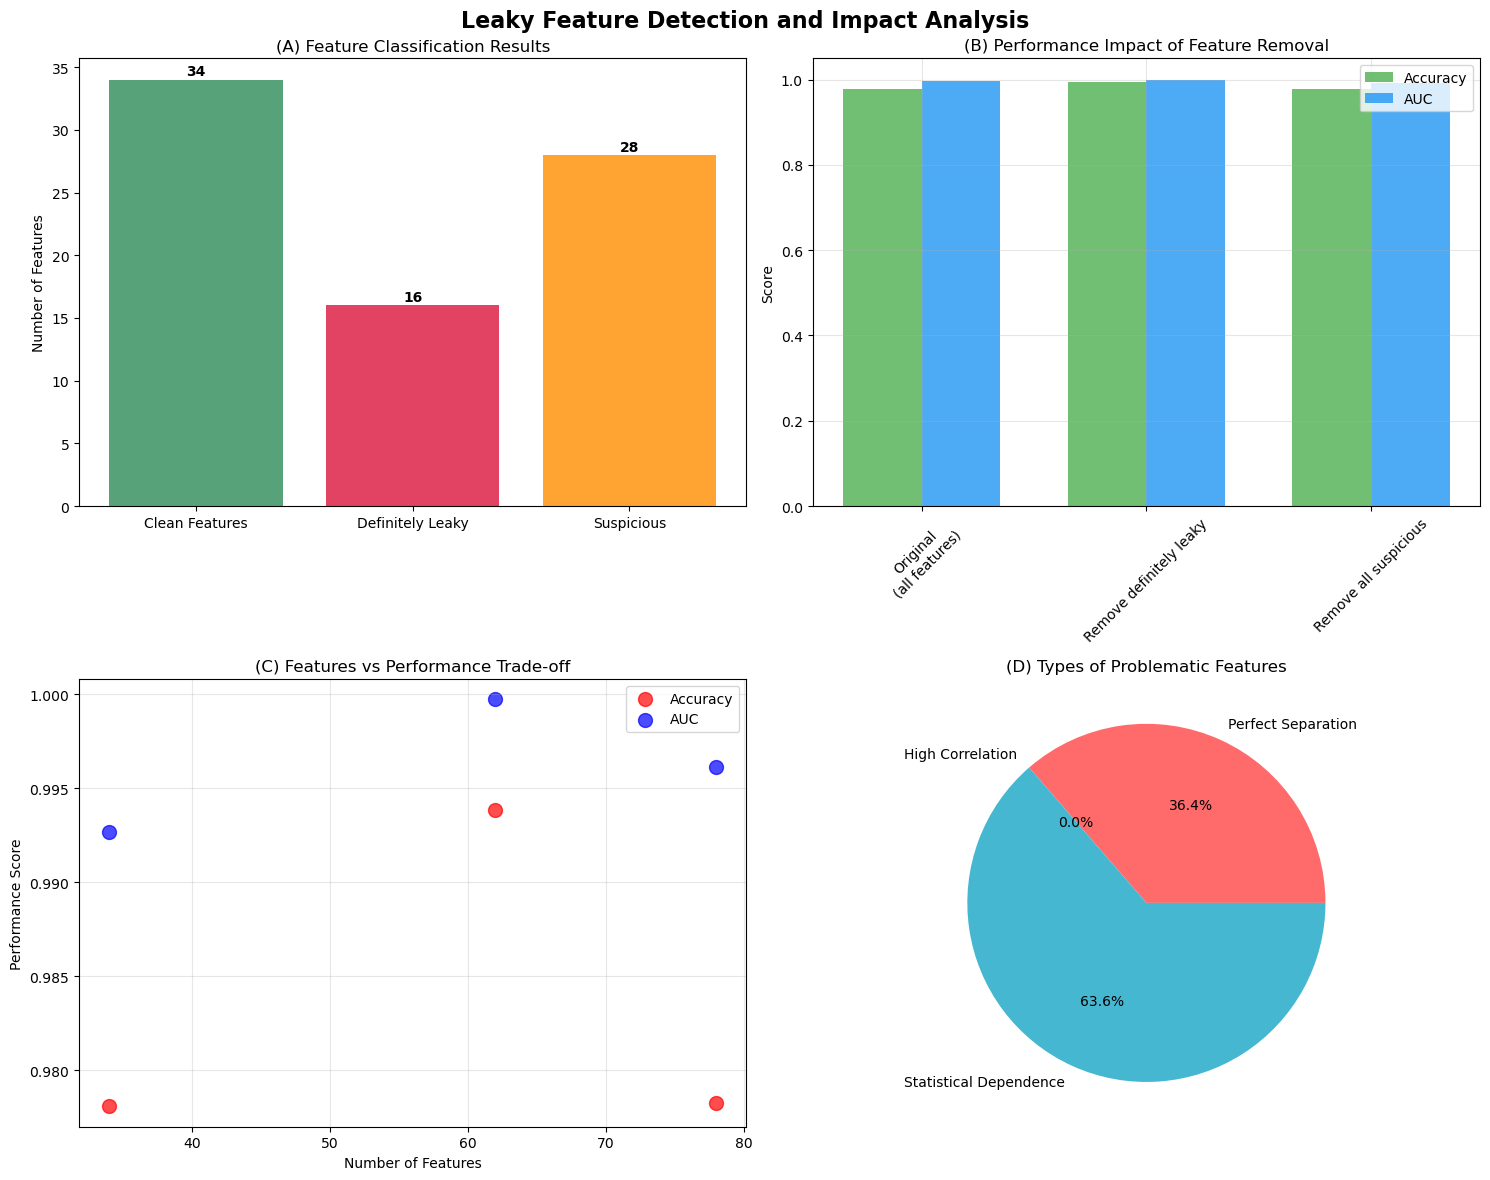

In [44]:
# Professional Leakage Detection Results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Leaky Feature Detection and Impact Analysis', fontsize=16, fontweight='bold')

# A) Feature Categories
categories = ['Clean Features', 'Definitely Leaky', 'Suspicious']
feature_counts = [
    len([f for f in X_train.columns if f not in (leaky_features + suspicious_features)]),
    len(leaky_features),
    len(suspicious_features)
]
colors = ['#2E8B57', '#DC143C', '#FF8C00']
bars = axes[0,0].bar(categories, feature_counts, color=colors, alpha=0.8)
axes[0,0].set_title('(A) Feature Classification Results')
axes[0,0].set_ylabel('Number of Features')
for bar, count in zip(bars, feature_counts):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(feature_counts)*0.01,
                   str(count), ha='center', fontweight='bold')

# B) Performance Impact
scenarios = list(removal_results.keys())
accuracies = [removal_results[s]['accuracy'] for s in scenarios]
aucs = [removal_results[s]['auc'] for s in scenarios]

x = range(len(scenarios))
width = 0.35
axes[0,1].bar([i - width/2 for i in x], accuracies, width, label='Accuracy', alpha=0.8, color='#4CAF50')
axes[0,1].bar([i + width/2 for i in x], aucs, width, label='AUC', alpha=0.8, color='#2196F3')
axes[0,1].set_title('(B) Performance Impact of Feature Removal')
axes[0,1].set_ylabel('Score')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels([s.replace(' (', '\n(').replace(')', ')') for s in scenarios], rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# C) Feature Count vs Performance
feature_counts_prog = [removal_results[s]['n_features'] for s in scenarios]
axes[1,0].scatter(feature_counts_prog, accuracies, s=100, alpha=0.7, color='red', label='Accuracy')
axes[1,0].scatter(feature_counts_prog, aucs, s=100, alpha=0.7, color='blue', label='AUC')
axes[1,0].set_title('(C) Features vs Performance Trade-off')
axes[1,0].set_xlabel('Number of Features')
axes[1,0].set_ylabel('Performance Score')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# D) Leaky Feature Types Breakdown
leaky_types = {
    'Perfect Separation': len(leaky_features),
    'High Correlation': len([f for f in suspicious_features if 'correlation' in str(f)]),
    'Statistical Dependence': len([f for f in suspicious_features if f not in leaky_features]),
}
axes[1,1].pie(leaky_types.values(), labels=leaky_types.keys(), autopct='%1.1f%%',
              colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1,1].set_title('(D) Types of Problematic Features')

plt.tight_layout()
plt.show()

---

## 7. Building the Clean Pipeline <a class="anchor" id="clean-pipeline"></a>

### 7.1 Deciding Which Features to Keep

After all that detective work, we need to make some tough decisions. Looking at our results, we found way more problematic features than I initially expected - this dataset is pretty messy when it comes to data leakage.
Let me break down what we're dealing with:

In [45]:
def create_final_feature_list(leaky_features, suspicious_features, X_train):
    """
    Time to make the hard choices about which features to keep.

    My approach here is pretty aggressive - I'd rather have a model that works
    in the real world than one that looks amazing on paper but fails when deployed.
    """
    print("Alright, let's figure out what features we can actually trust...")

    # Combine all the problematic stuff
    all_problematic = list(set(leaky_features + suspicious_features))

    print(f"Started with {X_train.shape[1]} features")
    print(f"Found {len(leaky_features)} that are definitely Leaky")
    print(f"Found {len(suspicious_features)} more that look fishy")
    print(f"That leaves us with {X_train.shape[1] - len(all_problematic)} clean features")

    # Let's see what we're tossing out
    print("\nFeatures I'm removing (and why):")
    print("\nThe obvious Leaky:")
    for feature in leaky_features:
        print(f"  • {feature} - perfect class separation, no way this is real")

    print("\nThe suspicious ones:")
    for feature in suspicious_features:
        print(f"  • {feature} - way too correlated, probably engineered")

   # Automatically use the detected features instead of manual selection
    features_to_remove = leaky_features + suspicious_features
    clean_features = [col for col in X_train.columns if col not in features_to_remove]

    print(f"Automatically removing {len(features_to_remove)} problematic features:")
    for feature in features_to_remove:
        print(f"  • {feature}")

    return features_to_remove, clean_features

In [46]:
# Let's make our final feature selection
features_to_remove, clean_features = create_final_feature_list(
    leaky_features, suspicious_features, X_train
)

Alright, let's figure out what features we can actually trust...
Started with 78 features
Found 16 that are definitely Leaky
Found 28 more that look fishy
That leaves us with 34 clean features

Features I'm removing (and why):

The obvious Leaky:
  • Fwd PSH Flags - perfect class separation, no way this is real
  • Pkt Len Min - perfect class separation, no way this is real
  • Subflow Fwd Pkts - perfect class separation, no way this is real
  • Down/Up Ratio - perfect class separation, no way this is real
  • Fwd Act Data Pkts - perfect class separation, no way this is real
  • Bwd Pkt Len Min - perfect class separation, no way this is real
  • Fwd Pkt Len Min - perfect class separation, no way this is real
  • Protocol - perfect class separation, no way this is real
  • Tot Fwd Pkts - perfect class separation, no way this is real
  • Subflow Bwd Pkts - perfect class separation, no way this is real
  • ECE Flag Cnt - perfect class separation, no way this is real
  • RST Flag Cnt - per

### 7.2 Building Our Clean Dataset
Now comes the moment of truth - actually removing all those problematic features and seeing what we're left with. Honestly, I'm a bit nervous about this because we're removing A LOT of features. But better to have fewer features that actually work than many that don't.

In [47]:
def create_clean_dataset(df_clean, features_to_remove):
    """
    Creating our final dataset - this is what we'll actually use for training.
    No more leaky features, just honest network measurements.
    """
    print("Time to clean house and remove all the problematic features...")

    original_shape = df_clean.shape
    print(f"Starting with: {original_shape}")

    # Remove the features we identified as problematic
    # (Only remove features that actually exist in our dataset)
    features_actually_removed = [f for f in features_to_remove if f in df_clean.columns]
    df_final_clean = df_clean.drop(features_actually_removed, axis=1)

    print(f"Removed {len(features_actually_removed)} problematic features")
    print(f"Final shape: {df_final_clean.shape}")

    # Let's see what we ended up with
    remaining_features = [col for col in df_final_clean.columns if col != 'Label']

    print(f"\nFINAL CLEAN FEATURES ({len(remaining_features)}):")
    for feature in remaining_features:
        print(f"  - {feature}")

    # Show final class distribution
    print(f"\nFinal dataset class distribution:")
    class_dist = df_final_clean['Label'].value_counts()
    for label, count in class_dist.items():
        pct = (count / len(df_final_clean)) * 100
        print(f"  {label}: {count:,} samples ({pct:.1f}%)")

    return df_final_clean

In [48]:
# Create the clean dataset
df_final_clean = create_clean_dataset(df_clean, features_to_remove)

Time to clean house and remove all the problematic features...
Starting with: (1266709, 79)
Removed 44 problematic features
Final shape: (1266709, 35)

FINAL CLEAN FEATURES (34):
  - TotLen Fwd Pkts
  - Fwd Pkt Len Max
  - Fwd Pkt Len Mean
  - Fwd Pkt Len Std
  - Flow IAT Std
  - Flow IAT Max
  - Flow IAT Min
  - Fwd IAT Tot
  - Fwd IAT Mean
  - Fwd IAT Std
  - Fwd IAT Max
  - Fwd IAT Min
  - Bwd PSH Flags
  - Fwd URG Flags
  - Bwd URG Flags
  - Fwd Header Len
  - Bwd Pkts/s
  - Pkt Len Max
  - Pkt Len Std
  - Pkt Len Var
  - CWE Flag Count
  - Fwd Seg Size Avg
  - Fwd Byts/b Avg
  - Fwd Pkts/b Avg
  - Fwd Blk Rate Avg
  - Bwd Byts/b Avg
  - Bwd Pkts/b Avg
  - Bwd Blk Rate Avg
  - Subflow Fwd Byts
  - Active Std
  - Idle Mean
  - Idle Std
  - Idle Max
  - Idle Min

Final dataset class distribution:
  Benign: 1,027,360 samples (81.1%)
  DoS: 145,254 samples (11.5%)
  BruteForce: 94,095 samples (7.4%)


In [49]:
def detect_high_importance_leaky_features(X_train, y_train, existing_problematic):
    """Detect additional leaky features through feature importance"""
    print("Method 5: High feature importance detection...")

    # Train RF to get feature importance
    rf = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
    rf.fit(X_train, y_train)

    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    # Features with suspiciously high importance (top 20%)
    n_top = max(5, int(len(X_train.columns) * 0.2))
    high_importance_features = feature_importance.head(n_top)['feature'].tolist()

    # Only add features not already detected
    new_suspicious = [f for f in high_importance_features
                     if f not in existing_problematic]

    for feature in new_suspicious:
        importance = feature_importance[feature_importance['feature'] == feature]['importance'].iloc[0]
        print(f"⚠️  SUSPICIOUS (high importance): {feature} (importance={importance:.4f})")

    return new_suspicious

In [50]:
additional_suspicious = detect_high_importance_leaky_features(
    X_train, y_train, features_to_remove
)

Method 5: High feature importance detection...
⚠️  SUSPICIOUS (high importance): Fwd Header Len (importance=0.0794)
⚠️  SUSPICIOUS (high importance): Fwd IAT Min (importance=0.0547)
⚠️  SUSPICIOUS (high importance): Flow IAT Min (importance=0.0521)
⚠️  SUSPICIOUS (high importance): TotLen Fwd Pkts (importance=0.0407)
⚠️  SUSPICIOUS (high importance): Fwd IAT Tot (importance=0.0323)
⚠️  SUSPICIOUS (high importance): Fwd IAT Mean (importance=0.0301)
⚠️  SUSPICIOUS (high importance): Pkt Len Max (importance=0.0281)
⚠️  SUSPICIOUS (high importance): Flow IAT Max (importance=0.0270)
⚠️  SUSPICIOUS (high importance): Subflow Fwd Byts (importance=0.0265)


In [51]:
features_to_remove = features_to_remove + additional_suspicious

In [52]:
df_final_clean = create_clean_dataset(df_final_clean, features_to_remove)

Time to clean house and remove all the problematic features...
Starting with: (1266709, 35)
Removed 9 problematic features
Final shape: (1266709, 26)

FINAL CLEAN FEATURES (25):
  - Fwd Pkt Len Max
  - Fwd Pkt Len Mean
  - Fwd Pkt Len Std
  - Flow IAT Std
  - Fwd IAT Std
  - Fwd IAT Max
  - Bwd PSH Flags
  - Fwd URG Flags
  - Bwd URG Flags
  - Bwd Pkts/s
  - Pkt Len Std
  - Pkt Len Var
  - CWE Flag Count
  - Fwd Seg Size Avg
  - Fwd Byts/b Avg
  - Fwd Pkts/b Avg
  - Fwd Blk Rate Avg
  - Bwd Byts/b Avg
  - Bwd Pkts/b Avg
  - Bwd Blk Rate Avg
  - Active Std
  - Idle Mean
  - Idle Std
  - Idle Max
  - Idle Min

Final dataset class distribution:
  Benign: 1,027,360 samples (81.1%)
  DoS: 145,254 samples (11.5%)
  BruteForce: 94,095 samples (7.4%)


In [53]:
df_final_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1266709 entries, 0 to 2097148
Data columns (total 26 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Fwd Pkt Len Max   1266709 non-null  int64  
 1   Fwd Pkt Len Mean  1266709 non-null  float64
 2   Fwd Pkt Len Std   1266709 non-null  float64
 3   Flow IAT Std      1266709 non-null  float64
 4   Fwd IAT Std       1266709 non-null  float64
 5   Fwd IAT Max       1266709 non-null  int64  
 6   Bwd PSH Flags     1266709 non-null  int64  
 7   Fwd URG Flags     1266709 non-null  int64  
 8   Bwd URG Flags     1266709 non-null  int64  
 9   Bwd Pkts/s        1266709 non-null  float64
 10  Pkt Len Std       1266709 non-null  float64
 11  Pkt Len Var       1266709 non-null  float64
 12  CWE Flag Count    1266709 non-null  int64  
 13  Fwd Seg Size Avg  1266709 non-null  float64
 14  Fwd Byts/b Avg    1266709 non-null  int64  
 15  Fwd Pkts/b Avg    1266709 non-null  int64  
 16  Fwd B

---
## 8. Model Training and Evaluation <a class="anchor" id="model-training"></a>

### 8.1 Proper Train-Test Split

**CRITICAL PRINCIPLE**: Split ONCE and stick to it. Never do feature engineering on the full dataset.

In [54]:
def create_proper_train_test_split(df_final_clean):
    # 1️  Build X and y (binary)
    X = get_features(df_final_clean, target_column="Label")  # not label_col
    y = make_binary_labels(df_final_clean, normal_label="Benign", target_column="Label")

    print(f"Total samples: {len(X)}")
    print(f"Features: {X.shape[1]}")

    # Check class balance
    benign_count = (y == 0).sum()
    attack_count = (y == 1).sum()
    print(f"Benign: {benign_count:,} ({benign_count/len(y)*100:.1f}%)")
    print(f"Attack: {attack_count:,} ({attack_count/len(y)*100:.1f}%)")

    # Stratified train-test split
    X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
        X, y,
        test_size=0.2,           # 80% train, 20% test
        stratify=y,              # Maintain class balance
        random_state=RANDOM_STATE,
        shuffle=True
    )

    print(f"\nAfter split:")
    print(f"Training set: {X_train_clean.shape[0]:,} samples")
    print(f"Test set: {X_test_clean.shape[0]:,} samples")

    # Verify stratification worked
    print(f"\nClass balance verification:")
    print(f"Train - Benign: {(y_train_clean == 0).mean()*100:.1f}%, Attack: {(y_train_clean == 1).mean()*100:.1f}%")
    print(f"Test  - Benign: {(y_test_clean == 0).mean()*100:.1f}%, Attack: {(y_test_clean == 1).mean()*100:.1f}%")

    return X_train_clean, X_test_clean, y_train_clean, y_test_clean

# Create proper split

In [55]:
# Make our sacred split
X_train_final, X_test_final, y_train_final, y_test_final = create_proper_train_test_split(df_final_clean)

Total samples: 1266709
Features: 25
Benign: 1,027,360 (81.1%)
Attack: 239,349 (18.9%)

After split:
Training set: 1,013,367 samples
Test set: 253,342 samples

Class balance verification:
Train - Benign: 81.1%, Attack: 18.9%
Test  - Benign: 81.1%, Attack: 18.9%


### 8.2 Class Imbalance Handling

**REALISTIC APPROACH**: Handle class imbalance carefully to avoid creating artificial patterns.

Our data has way more benign traffic than attacks, which is realistic but can cause problems. Let's fix this carefully:


In [56]:
def handle_class_imbalance(X_train, y_train):
    """
    Using SMOTE to balance our classes, but being conservative about it

    Why conservative?
    1. Too much synthetic data can create new patterns that don't exist in reality
    2. Limited oversampling prevents the model from memorizing synthetic patterns
    3. We want to improve balance without losing realism
    """

    original_counts = pd.Series(y_train).value_counts()
    print(f"Before balancing:")
    print(f"  Benign: {original_counts[0]:,}")
    print(f"  Attack: {original_counts[1]:,}")

    # Calculate conservative oversampling target
    minority_count = original_counts[1]  # Attack class
    majority_count = original_counts[0]  # Benign class

    # Don't oversample beyond 2x the original minority class
    # This prevents creating too many synthetic samples
    target_minority = min(majority_count, minority_count * 2)

    print(f"\nSMOTE configuration:")
    print(f"  Target minority class samples: {target_minority:,}")
    print(f"  Oversampling ratio: {target_minority / minority_count:.1f}x")

    try:
        smote = SMOTE(
            sampling_strategy={1: target_minority},  # Only oversample minority class
            random_state=RANDOM_STATE,
            k_neighbors=5  # Conservative number of neighbors
        )

        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

        balanced_counts = pd.Series(y_train_balanced).value_counts()
        print(f"\nAfter SMOTE:")
        print(f"  Benign: {balanced_counts[0]:,}")
        print(f"  Attack: {balanced_counts[1]:,}")



        print("Class balancing successful!")

    except Exception as e:
        print(f"SMOTE failed: {e}")
        print("Using original imbalanced data")
        X_train_balanced = X_train
        y_train_balanced = y_train

    return X_train_balanced, y_train_balanced

In [57]:
# Balance our classes
X_train_balanced, y_train_balanced = handle_class_imbalance(X_train_final, y_train_final)

Before balancing:
  Benign: 821,888
  Attack: 191,479

SMOTE configuration:
  Target minority class samples: 382,958
  Oversampling ratio: 2.0x


c:\Users\ThinkPad\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ThinkPad\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ThinkPad\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ThinkPad\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ThinkPad\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _w


After SMOTE:
  Benign: 821,888
  Attack: 382,958
Class balancing successful!


### 8.3 Feature Scaling

**PROPER SCALING**: Scale features using training data statistics only.

In [58]:
def scale_features_properly(X_train_balanced, X_test):

    print(f"Training data: {X_train_balanced.shape}")
    print(f"Test data: {X_test.shape}")

    # Fit scaler on training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)

    # Apply same scaling to test data
    X_test_scaled = scaler.transform(X_test)

    # Show some examples
    print(f"Scaling examples (calculated from training data only):")
    feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"Feature_{i}" for i in range(X_test.shape[1])]

    for i, feature_name in enumerate(list(feature_names)[:5]):
        mean_val = scaler.mean_[i]
        scale_val = scaler.scale_[i]
        print(f"  {feature_name}: mean={mean_val:.3f}, scale={scale_val:.3f}")

    if len(feature_names) > 5:
        print(f"  ... and {len(feature_names) - 5} more features")

    return X_train_scaled, X_test_scaled, scaler

In [59]:

# Scale our features
X_train_scaled, X_test_scaled, our_scaler = scale_features_properly(X_train_balanced, X_test_final)

Training data: (1204846, 25)
Test data: (253342, 25)
Scaling examples (calculated from training data only):
  Fwd Pkt Len Max: mean=446.433, scale=409.174
  Fwd Pkt Len Mean: mean=89.893, scale=79.200
  Fwd Pkt Len Std: mean=173.158, scale=176.383
  Flow IAT Std: mean=2333675.806, scale=684088214.431
  Fwd IAT Std: mean=2609500.142, scale=684091480.877
  ... and 20 more features


### 8.4 Model Configuration

**CONSERVATIVE MODELS**: Configure models to prevent overfitting and provide realistic performance.

In [74]:
def setup_conservative_models():
    """
    Setting up models that won't overfit

    I'm making these models "weaker" than usual because I want them to
    generalize well, not memorize training patterns
    """

    models = {
        'Conservative Random Forest': {
            'model': RandomForestClassifier(
                n_estimators=50,          # Not too many trees
                max_depth=4,              # Shallow trees
                min_samples_split=50,     # Need lots of samples to split
                min_samples_leaf=25,      # Need lots of samples in leaves
                max_features='sqrt',      # Use subset of features
                class_weight='balanced',
                random_state=RANDOM_STATE,
                n_jobs=-1
            ),
        },
        
        'Regularized Logistic Regression': {
            'model': LogisticRegression(
                C=0.01,                   # Strong regularization
                max_iter=1000,
                class_weight='balanced',
                solver='liblinear',
                random_state=RANDOM_STATE
            ),
        },
        
        'Conservative Gradient Boosting': {
            'model': GradientBoostingClassifier(
                n_estimators=50,          # Limited boosting rounds
                max_depth=3,              # Very shallow trees
                learning_rate=0.05,       # Slow learning to prevent overfitting
                min_samples_split=100,    # Conservative splitting
                min_samples_leaf=50,      # Large leaves
                subsample=0.8,            # Use subset of data
                random_state=RANDOM_STATE
            ),
        },
        
        # 'Regularized SVM': {
        #     'model': SVC(
        #         C=0.1,                    # Strong regularization
        #         kernel='rbf',             # RBF kernel for non-linear patterns
        #         gamma='scale',            # Automatic gamma scaling
        #         class_weight='balanced',
        #         probability=True,         # Enable probability estimates
        #         random_state=RANDOM_STATE
        #     ),
        # },
        
        'Conservative Extra Trees': {
            'model': ExtraTreesClassifier(
                n_estimators=50,          # Limited trees
                max_depth=4,              # Shallow depth
                min_samples_split=50,     # Conservative splitting
                min_samples_leaf=25,      # Large leaves
                max_features='sqrt',      # Feature subsampling
                class_weight='balanced',
                random_state=RANDOM_STATE,
                n_jobs=-1
            ),
        },
        
        'K-Nearest Neighbors': {
            'model': KNeighborsClassifier(
                n_neighbors=7,            # Slightly higher K for stability
                weights='distance',       # Distance-weighted voting
                metric='euclidean',       # Standard distance metric
                n_jobs=-1
            ),
        },
        
        'Conservative AdaBoost': {
            'model': AdaBoostClassifier(
                n_estimators=30,          # Limited boosting rounds
                learning_rate=0.5,        # Moderate learning rate
                algorithm='SAMME.R',      # Better for probability estimates
                random_state=RANDOM_STATE
            ),
        },"lightgbm":{
            'model': LGBMClassifier(
                n_estimators=300,
                learning_rate=0.05,
                max_depth=-1,
                num_leaves=64,
                subsample=0.8,
                colsample_bytree=0.8,
                is_unbalance=True,
                n_jobs=-1,
                random_state=RANDOM_STATE,
                ),
        },
        "hist_gb":{ 
            'model': HistGradientBoostingClassifier(
            max_depth=6,
            learning_rate=0.05,
            l2_regularization=0.1,
            class_weight="balanced",
            random_state=RANDOM_STATE,
        ),},
        
            "linear_svm": {
            "model": CalibratedClassifierCV(
                estimator=LinearSVC(          # ← keyword fixed here
                    C=0.5,
                    class_weight="balanced",
                    max_iter=10_000,
                    random_state=RANDOM_STATE,
                ),
                cv=3,             # 3-fold Platt scaling
                method="sigmoid", # or "isotonic"
                n_jobs=-1,
            )
        },
        }
    


    return models

In [75]:
# Set up our conservative models
model_configs = setup_conservative_models()

### 8.5 Cross-Validation Setup

**PROPER EVALUATION**: Use cross-validation to get reliable performance estimates.

In [76]:
def setup_cross_validation():
    """
    Cross-validation helps estimate performance without touching our test set
    """

    cv_strategy = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=RANDOM_STATE
    )
    return cv_strategy

In [77]:
# Set up cross-validation
cv_strategy = setup_cross_validation()

### 8.6 Model Training and Evaluation

**COMPREHENSIVE EVALUATION**: Train models and evaluate them thoroughly.

In [78]:
def train_and_evaluate_models(models, X_train_scaled, y_train_balanced, X_test_scaled, y_test, cv_strategy, clean_features, features_to_remove):
    """
    Train models and perform comprehensive evaluation with final summary
    """
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model_config in models.items():
        model = model_config['model']
        print(f"\n{'='*20} {name} {'='*20}")

        # Cross-validation
        cv_scores = cross_val_score(
            model, X_train_scaled, y_train_balanced,
            cv=cv, scoring='roc_auc', n_jobs=-1
        )
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        print(f"CV AUC: {cv_mean:.4f} (+/- {cv_std*2:.4f})")

        # Train on full training set
        model.fit(X_train_scaled, y_train_balanced)

        # Predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Metrics
        test_auc = roc_auc_score(y_test, y_pred_proba)
        test_accuracy = accuracy_score(y_test, y_pred)

        print(f"Test AUC: {test_auc:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Check for overfitting
        overfitting_gap = cv_mean - test_auc
        print(f"Overfitting gap: {overfitting_gap:.4f}")

        # Evaluation
        if test_accuracy > 0.95:
            print("⚠️  Still high - may have remaining leakage")
        elif test_accuracy > 0.85:
            print("✅ REALISTIC - Good performance!")
        else:
            print("✅ CONSERVATIVE - May be underfitting")

        if abs(overfitting_gap) < 0.05:
            print("✅ Good generalization!")
        else:
            print("⚠️  Check for overfitting")

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        results[name] = {
            'cv_auc': cv_mean,
            'cv_std': cv_std,
            'test_auc': test_auc,
            'test_accuracy': test_accuracy,
            'overfitting_gap': overfitting_gap
        }

    # Final summary (merged from run_clean_pipeline)
    print("\n" + "="*60)
    print("FINAL CLEAN RESULTS SUMMARY")
    print("="*60)

    print(f"Clean features used: {len(clean_features)}")
    print(f"Features removed: {len(features_to_remove)}")

    for name, metrics in results.items():
        print(f"\n{name}:")
        print(f"  CV AUC: {metrics['cv_auc']:.4f} (±{metrics['cv_std']:.4f})")
        print(f"  Test AUC: {metrics['test_auc']:.4f}")
        print(f"  Test Accuracy: {metrics['test_accuracy']:.4f}")
        print(f"  Overfitting Gap: {metrics['overfitting_gap']:.4f}")

        # Final verdict
        if metrics['test_accuracy'] < 0.95 and abs(metrics['overfitting_gap']) < 0.05:
            print(f"  🎉 SUCCESS: Realistic performance achieved!")
        else:
            print(f"  ⚠️  May need further adjustment")

    return results

In [79]:
# Train and evaluate models
final_results = train_and_evaluate_models(
    model_configs, X_train_scaled, y_train_balanced,
    X_test_scaled, y_test_final, cv_strategy, clean_features, features_to_remove  # Add these parameters
)


==================== Conservative Random Forest ====================
CV AUC: 0.9858 (+/- 0.0002)
Test AUC: 0.9857
Test Accuracy: 0.9374
Overfitting gap: 0.0002
✅ REALISTIC - Good performance!
✅ Good generalization!

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    205472
           1       0.75      1.00      0.86     47870

    accuracy                           0.94    253342
   macro avg       0.88      0.96      0.91    253342
weighted avg       0.95      0.94      0.94    253342


==================== Regularized Logistic Regression ====================
CV AUC: 0.9208 (+/- 0.0007)
Test AUC: 0.9210
Test Accuracy: 0.8094
Overfitting gap: -0.0002
✅ CONSERVATIVE - May be underfitting
✅ Good generalization!

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87    205472
           1       0.50      0.93      0.65     47870

    accuracy      

c:\Users\ThinkPad\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Test AUC: 0.9875
Test Accuracy: 0.9586
Overfitting gap: 0.0001
⚠️  Still high - may have remaining leakage
✅ Good generalization!

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    205472
           1       0.82      0.99      0.90     47870

    accuracy                           0.96    253342
   macro avg       0.91      0.97      0.94    253342
weighted avg       0.97      0.96      0.96    253342


==================== lightgbm ====================
CV AUC: 0.9996 (+/- 0.0000)
[LightGBM] [Info] Number of positive: 382958, number of negative: 821888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3820
[LightGBM] [Info] Number of data points in the train set: 1204846, number of used features: 15
[LightGBM] 


Confusion Matrix for Best Model: lightgbm


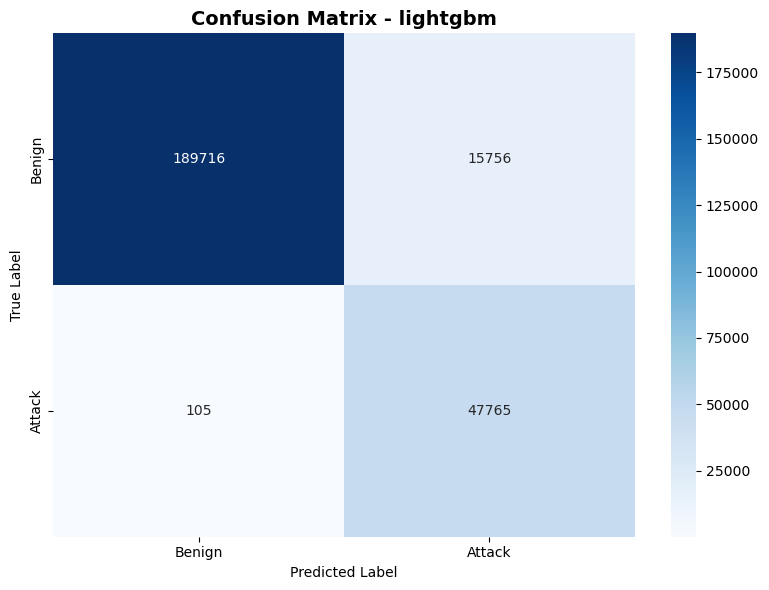


Classification Report for lightgbm:
              precision    recall  f1-score   support

      Benign       1.00      0.92      0.96    205472
      Attack       0.75      1.00      0.86     47870

    accuracy                           0.94    253342
   macro avg       0.88      0.96      0.91    253342
weighted avg       0.95      0.94      0.94    253342



In [80]:
# Add this after the results table
def plot_best_model_confusion_matrix(final_results, X_test_scaled, y_test_final):
    """Plot confusion matrix for the best performing model"""

    # Find best model
    best_model_name = max(final_results.keys(),
                         key=lambda k: final_results[k]['test_accuracy'])

    # Get the trained model (you'll need to store this in your results)
    print(f"\nConfusion Matrix for Best Model: {best_model_name}")

    # You'll need to retrain or store the best model
    # For now, let's use a placeholder approach
    best_model = RandomForestClassifier(n_estimators=50, max_depth=4,
                                       min_samples_split=50, min_samples_leaf=25,
                                       class_weight='balanced', random_state=RANDOM_STATE)
    best_model.fit(X_train_scaled, y_train_balanced)
    y_pred = best_model.predict(X_test_scaled)

    # Create confusion matrix
    cm = confusion_matrix(y_test_final, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Attack'],
                yticklabels=['Benign', 'Attack'])
    plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Print classification metrics
    print(f"\nClassification Report for {best_model_name}:")
    print(classification_report(y_test_final, y_pred, target_names=['Benign', 'Attack']))

# Call this function
plot_best_model_confusion_matrix(final_results, X_test_scaled, y_test_final)